In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/VIP/

/content/drive/.shortcut-targets-by-id/1dVOVc-ciGmV3PT28TmykeenETA1YmUl7/VIP Object Detection


In [3]:
import torch
from config import Config
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pathlib
import numpy as np

from utils import (
    get_model_instance_segmentation,
    collate_fn,
    get_transform,
    myOwnDataset,
)

In [4]:
config = Config()
config.num_epochs = 50

In [5]:
my_dataset = myOwnDataset(
    root=config.train_data_dir, annotation=config.train_coco, transforms=get_transform()
)

train_size = int(.8 * len(my_dataset))
test_size = len(my_dataset) - train_size
    
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

# own DataLoader
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.train_batch_size,
    shuffle=config.train_shuffle_dl,
    #num_workers=config.num_workers_dl,
    collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


In [6]:
model = get_model_instance_segmentation(config.num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]

# Might not want to use SGD, use Adam instead
optimizer = torch.optim.SGD(
    params, lr=config.lr, momentum = config.momentum, weight_decay=config.weight_decay
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [1]:
from collections import defaultdict
train_loss_history = defaultdict(list)
for epoch in range(config.num_epochs):
        print(f"Epoch: {epoch}/{config.num_epochs}")
        model.train()
        i = 0
        classifier_loss = 0
        box_reg_loss = 0
        objectness_loss = 0
        rpn_box_reg_loss = 0
        for imgs, annotations in data_loader:
            i += 1
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
	
            #for a in annotations:
                # print(len(a['boxes']))
             #   if len(a['boxes']) == 0:
              #      print(a)
               #     a['boxes'] = torch.tensor([[0],[0],[0],[0]]).reshape(1, 4)

            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())
            classifier_loss += loss_dict['loss_classifier'].cpu().detach()
            box_reg_loss += loss_dict['loss_box_reg'].cpu().detach()
            objectness_loss += loss_dict['loss_objectness'].cpu().detach()
            rpn_box_reg_loss += loss_dict['loss_rpn_box_reg'].cpu().detach()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            print(f"Iteration: {i}/{len(data_loader)}, Loss: {losses}")
        train_loss_history['classifier_loss'].append(classifier_loss)
        train_loss_history['box_reg_loss'].append(box_reg_loss)
        train_loss_history['objectness_loss'].append(objectness_loss)
        train_loss_history['rpn_box_reg_loss'].append(rpn_box_reg_loss)
print(loss_dict)
torch.save(model.state_dict(), "model.pt")

NameError: ignored

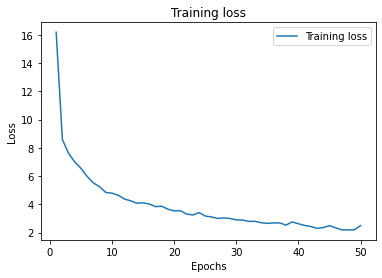

In [ ]:
train_loss_history['total_loss'] = np.zeros((config.num_epochs,))
for key in train_loss_history.keys():
  train_loss_history['total_loss'] += train_loss_history[key]
epochs = np.arange(1,config.num_epochs+1)
plt.plot(epochs, train_loss_history['total_loss'], label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = get_model_instance_segmentation(config.num_classes)
model.load_state_dict(torch.load('model.pt'))
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
img = test_dataset[0][0]
pred = model(torch.unsqueeze(img,0))
print(pred[0]['scores'])
mask = pred[0]['scores'] > 0.5
boxes = pred[0]['boxes'][mask]
label = pred[0]['labels'][mask]

tensor([0.9964, 0.9964, 0.3359, 0.1805], grad_fn=<IndexBackward0>)


In [ ]:
labels = []
for l in list(label.numpy()):
  labels.append(str(l))
labels

['1', '1', '1', '1']

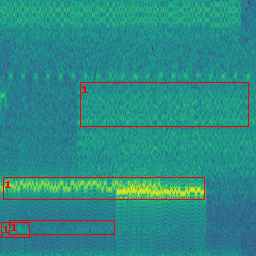

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToPILImage

img *= 255
# draw bounding box and fill color
result = draw_bounding_boxes(img.type(torch.uint8), boxes.type(torch.uint8),
                          labels=labels,
                          colors="red", 
                          fill=False)
  
# transform this image to PIL image
result = ToPILImage()(result)
  
# display output
result.show()
result